# **ASSINGMENT 2**

*Done by Ethan Ty, Osbert Villasis and Diego Plumed*

*16/02/2026*

# Assignment 2: Task 1
## CNN for STL-10 utilizing tensorflow.

This notebook is an implementation for the STL-10 dataset of a CNN model applied to acne data. Thus, it has been thoroughly adapted for its application; the data has been properly loaded and configured, and the particular data features consequently modified, in this case the data classes.



## Import libraries

We first import the pertinent libraries.

In [ ]:

# ----------------------------
# Required imports
# ----------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

###

## Load STL-10 Dataset


We load and split the data into 80% training and 20% test.

In [ ]:

import tensorflow_datasets as tfds

# ----------------------------
# PARAMETERS (adjust if needed)
# ----------------------------
BATCH_SIZE = 32
IMAGE_SIZE = 96  # STL-10 native size is 96x96

# ----------------------------
# LOAD DATA
# ----------------------------
(train_raw, val_raw, test_raw), ds_info = tfds.load(
    "stl10",
    split=["train[:80%]", "train[80%:]", "test"],
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features["label"].names
NUM_CLASSES = ds_info.features["label"].num_classes

print("Classes:", class_names)
print("NUM_CLASSES:", NUM_CLASSES)
print("Train:", tf.data.experimental.cardinality(train_raw).numpy())
print("Val:", tf.data.experimental.cardinality(val_raw).numpy())
print("Test:", tf.data.experimental.cardinality(test_raw).numpy())


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.LFKDY9_1.0.0/stl10-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.LFKDY9_1.0.0/stl10-test.tfrecord*...:   0%|          | 0/…

Generating unlabelled examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.LFKDY9_1.0.0/stl10-unlabelled.tfrecord*...:   0%|        …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
NUM_CLASSES: 10
Train: 4000
Val: 1000
Test: 8000


###

## Visualize Sample Images

In order to acquire a broader understanding of the new dataset, we display some of its elements, in this case images.

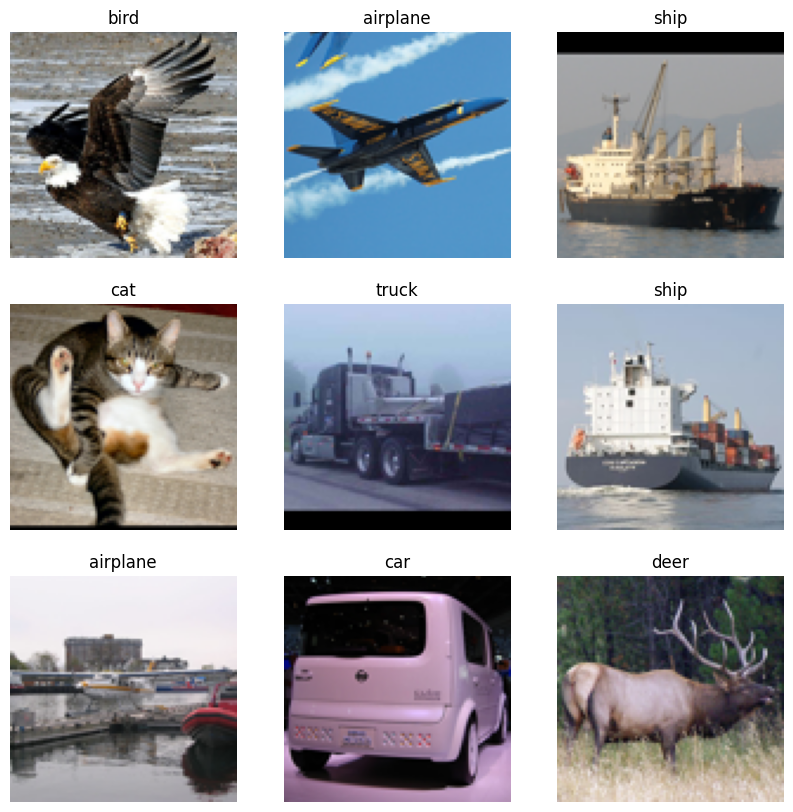

In [ ]:

import matplotlib.pyplot as plt

for images, labels in train_raw.batch(9).take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    plt.show()


###

## 4. Preprocessing, Normalization, Augmentation

In the following chunk, we normalise and augment the training data, so that the network is exposed to unusual patterns and, consequently, gains robustness and generalisation efficiency.

In [ ]:

# Reuse the same augmentation pattern as the acne notebook
normalization_layer = Rescaling(1./255)

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.10),
    RandomZoom(0.10),
])

def preprocess_train(x, y):
    # Ensure size is consistent (STL10 is already 96x96, but kept for safety)
    x = tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = data_augmentation(x, training=True)
    x = normalization_layer(x)
    return x, y

def preprocess_eval(x, y):
    x = tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = normalization_layer(x)
    return x, y

train_ds = (train_raw
            .shuffle(5000)
            .map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

valid_ds = (val_raw
            .map(preprocess_eval, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (test_raw
           .map(preprocess_eval, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE))


###

## Build CNN Model

We create the model. As activation function, ReLU is used, ending with softmax since we are dealing with a classification problem, and 3×3 kernels are applied. Regarding the optimizer, Adam is the chosen one, and for the loss function, cross-entropy, indeed.

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,186 (2.18 MB)

 Trainable params: 570,186 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

###

##  Train Model

To prevent overfitting in the training phase, we add early stopping and a learning rate scheduler.

In [ ]:
# ----------------------------
# CALLBACKS
# ----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ----------------------------
# TRAIN MODEL
# ----------------------------
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    callbacks=[early_stop, lr_scheduler],
    verbose=2
)

Epoch 1/50
125/125 - 92s - 738ms/step - accuracy: 0.1488 - loss: 2.2869 - val_accuracy: 0.2000 - val_loss: 2.0823 - learning_rate: 1.0000e-03
Epoch 2/50
125/125 - 85s - 683ms/step - accuracy: 0.2253 - loss: 1.9895 - val_accuracy: 0.2100 - val_loss: 2.0077 - learning_rate: 1.0000e-03
Epoch 3/50
125/125 - 163s - 1s/step - accuracy: 0.2623 - loss: 1.8626 - val_accuracy: 0.2930 - val_loss: 1.7685 - learning_rate: 1.0000e-03
Epoch 4/50
125/125 - 125s - 1000ms/step - accuracy: 0.3228 - loss: 1.7390 - val_accuracy: 0.3230 - val_loss: 1.7402 - learning_rate: 1.0000e-03
Epoch 5/50
125/125 - 89s - 715ms/step - accuracy: 0.3420 - loss: 1.6950 - val_accuracy: 0.3690 - val_loss: 1.5933 - learning_rate: 1.0000e-03
Epoch 6/50
125/125 - 87s - 695ms/step - accuracy: 0.3787 - loss: 1.6279 - val_accuracy: 0.3860 - val_loss: 1.6078 - learning_rate: 1.0000e-03
Epoch 7/50
125/125 - 88s - 702ms/step - accuracy: 0.3960 - loss: 1.5842 - val_accuracy: 0.4230 - val_loss: 1.5677 - learning_rate: 1.0000e-03
Epoch 

###

## Evaluate Model



In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 188ms/step - accuracy: 0.5790 - loss: 1.1836
Test Accuracy: 0.5903750061988831


The final obtained accuracy is 0.579, which translates into 57.9% of the test images being accurately labeled by the model.

###

## Confusion Matrix & Classification Report

For further insight into our model, we plot its corresponding confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true and predicted labels for test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

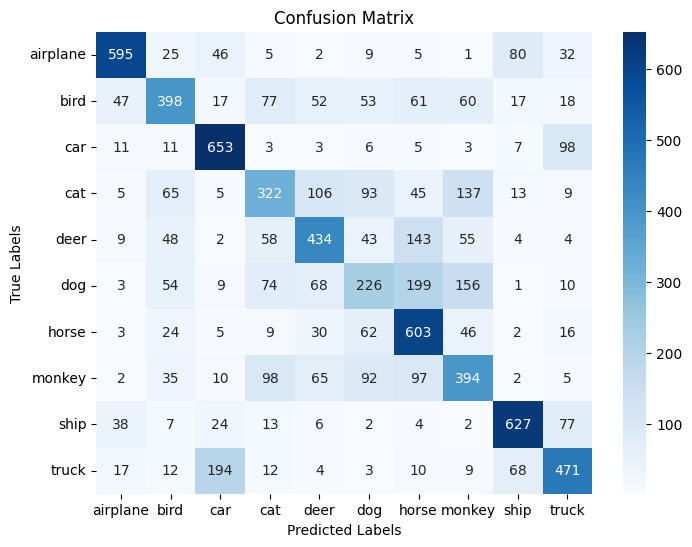

In [ ]:
# ----------------------------
# CONFUSION MATRIX
# ----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



We note that our model is really effective in airplane, car, horse, and ship classification. However, except for horses, animals seem to be poorly recognised. Moreover, trucks are remarkably mistaken for cars.

Alongside the general confusion matrix, we provide additional, more compact metrics.

In [ ]:
# ----------------------------
# CLASSIFICATION REPORT
# ----------------------------
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)



Classification Report:
               precision    recall  f1-score   support

    airplane       0.82      0.74      0.78       800
        bird       0.59      0.50      0.54       800
         car       0.68      0.82      0.74       800
         cat       0.48      0.40      0.44       800
        deer       0.56      0.54      0.55       800
         dog       0.38      0.28      0.33       800
       horse       0.51      0.75      0.61       800
      monkey       0.46      0.49      0.47       800
        ship       0.76      0.78      0.77       800
       truck       0.64      0.59      0.61       800

    accuracy                           0.59      8000
   macro avg       0.59      0.59      0.58      8000
weighted avg       0.59      0.59      0.58      8000



###

## Accuracy and Loss Curves

We finish our model study by plotting both accuracy and loss over epochs.

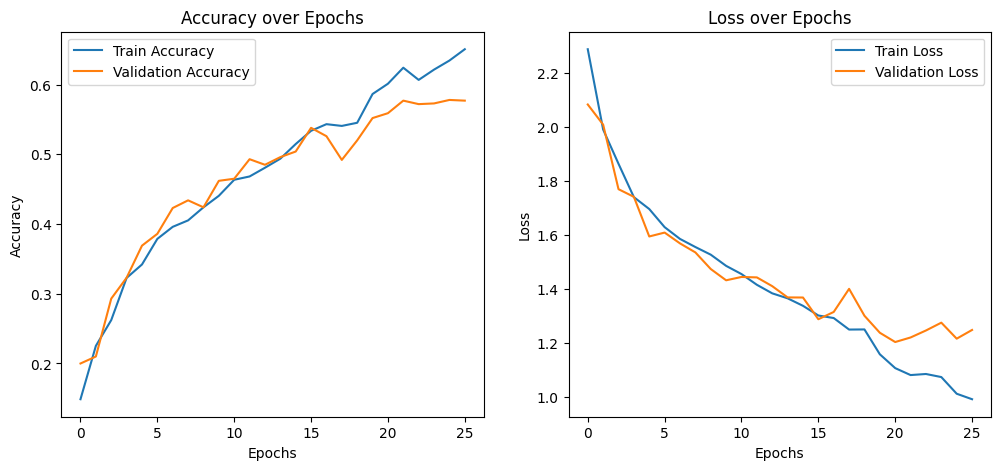

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Thanks to the early stopping, overfitting does not remarkably affect the model. Nevertheless, accuracy barely exceeds the random choice rate, whereas loss is small. We conclude that, although the model is optimal in terms of loss, we lack additional information that could enhance its accuracy, for instance more data.

###

###

###

# Assignment 2: Task 2

## STL-10 CNN Classification

The second and final part of the assignment requires us to design and apply a CNN model to classify the complex STL-10 dataset, this time making use of the PyTorch package.

To effectively do so, we will firstly properly download, configure, and visualise the data. Afterwards, we reduce our problem to the simpler case of 2-class classification and generalise it to the computationally costlier 10-class classification. Our research will conclude with several tests on the CNN parameters, to deepen and better understand the black box it represents. The comparison between such tests will be based on their corresponding efficiency metrics, from which the most relevant will be the accuracy.

In [ ]:
# coding: utf-8

###

## Environment check

This cell ensures you are running the intended environment. If it fails, either activate that environment or comment out this cell.

In [ ]:
# Verify the environment is correct
import os
# if not 'CONDA_DEFAULT_ENV' in os.environ or os.environ['CONDA_DEFAULT_ENV'] != 'dl':
#    raise RuntimeError('This exercise requires \'dl\' conda environment activated')

###

## Imports

We import NumPy and Matplotlib for data handling and visualization, and PyTorch for building and training CNNs.


In [ ]:
# ===================
# for array manipulations, etc.
# ===================
import random
import numpy as np

# ===================
# for visualization
# ===================
from matplotlib import pyplot as plt

# ===================
# pytorch for CNN related things
# ===================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

###



## Load STL-10 (binary format)

If the dataset is already on the machine, we've developed the function `load_split()` to read the binary image/label files and reshape images to `(N, 3, 96, 96)`.
On the other hand, one may download the data directly from the cell.

In [ ]:
# ===================
# function to load the dataset and format the data as required for further processing
# ===================
# inputs:
#    split: string denoting whether the train or the test data is to be loaded
# outputs:
#    X: dataset inputs (images)
#    y: dataset outputs (labels for the images)
# ===================
def load_split(split):
    X_path = 'stl10_binary/{}_X.bin'.format(split)
    y_path = 'stl10_binary/{}_y.bin'.format(split)
    X = np.fromfile(X_path, dtype=np.uint8).reshape((-1, 3, 96, 96))
    X = np.moveaxis(X, 2, 3) # convert column-major to row-major (swap H/W)
    y = np.fromfile(y_path, dtype=np.uint8) # data type seems to be important here...
    y = y - 1 #convert range [1,10] to [0,9]
    print('-----------------')
    print('Loaded split "{}" with sizes: Images {}, labels {}'.format(split, X.shape, y.shape))
    return X, y


# ===================
# Download and extract the dataser if it's not already present
# ===================
import os
if not os.path.exists('stl10_binary'):
  print('Downloading and extracting STL-10 dataset...')
  !wget http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
  !tar -xzf stl10_binary.tar.gz
  print('Dataser download and extracted')

# ===================
# load the training and test datasets
# ===================
full_train_X, full_train_y = load_split('train')
full_test_X, full_test_y = load_split('test')

# ===================
# read the names of the classes in the dataset
# ===================
with open('stl10_binary/class_names.txt') as f:
    full_class_names = f.readlines()

 # ===================
 # strip trailing whitespace
 # ===================
full_class_names = [name.strip() for name in full_class_names]

# ===================
# print the list of names of all classes
# ===================
print('-----------------')
print('The classes in the dataset are: ')
print(list(enumerate(full_class_names)))

--2026-02-05 20:30:27--  http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2640397119 (2.5G) [application/x-gzip]
Saving to: ‘stl10_binary.tar.gz’

stl10_binary.tar.gz 100%[===================>]   2.46G  12.8MB/s    in 2m 37s  

2026-02-05 20:33:05 (16.0 MB/s) - ‘stl10_binary.tar.gz’ saved [2640397119/2640397119]

Dataser download and extracted
-----------------
Loaded split "train" with sizes: Images (5000, 3, 96, 96), labels (5000,)
-----------------
Loaded split "test" with sizes: Images (8000, 3, 96, 96), labels (8000,)
-----------------
The classes in the dataset are: 
[(0, 'airplane'), (1, 'bird'), (2, 'car'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'horse'), (7, 'monkey'), (8, 'ship'), (9, 'truck')]


###

## Visualize samples

We define a helper to display an image with its class name. The STL-10 images are stored as channels-first `(3, 96, 96)`, so we move the axes for plotting.


In [ ]:
# ===================
# function to show an example image and its label
# ===================
# inputs:
#    X: image
#    y: label
#    class_names: list of names of all classes so that the class name corresponding to the label can be identified
# outputs:
#    None
# ===================
def visualize_sample(X, y, class_names):
    X_vis = np.moveaxis(X, 0, 2) # convert Channel,Width,Height order to W,H,C
    plt.figure()
    plt.imshow(X_vis, interpolation='nearest')
    plt.axis('off')
    plt.title('Class id={}, Name={}'.format(y, class_names[y]))

###

### Show one random training image

This cell shows a random image. If more are wanted, the following generates a grid.

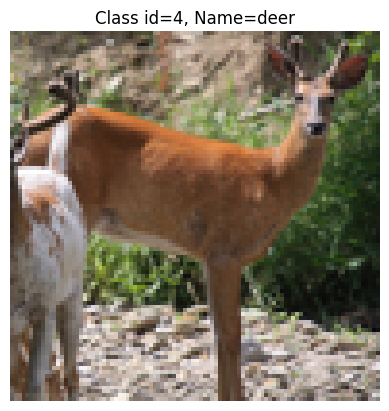

In [ ]:
# ===================
# choose a random image and display it
# you may run this cell multiple times to get an idea of the different images in the dataset
# alternatively, modify the function 'visualize_sample' to display several (4/8/16) different images along with their labels
# ===================
i = random.randint(0, full_train_X.shape[0]-1)
visualize_sample(full_train_X[i],
                 full_train_y[i],
                 full_class_names)

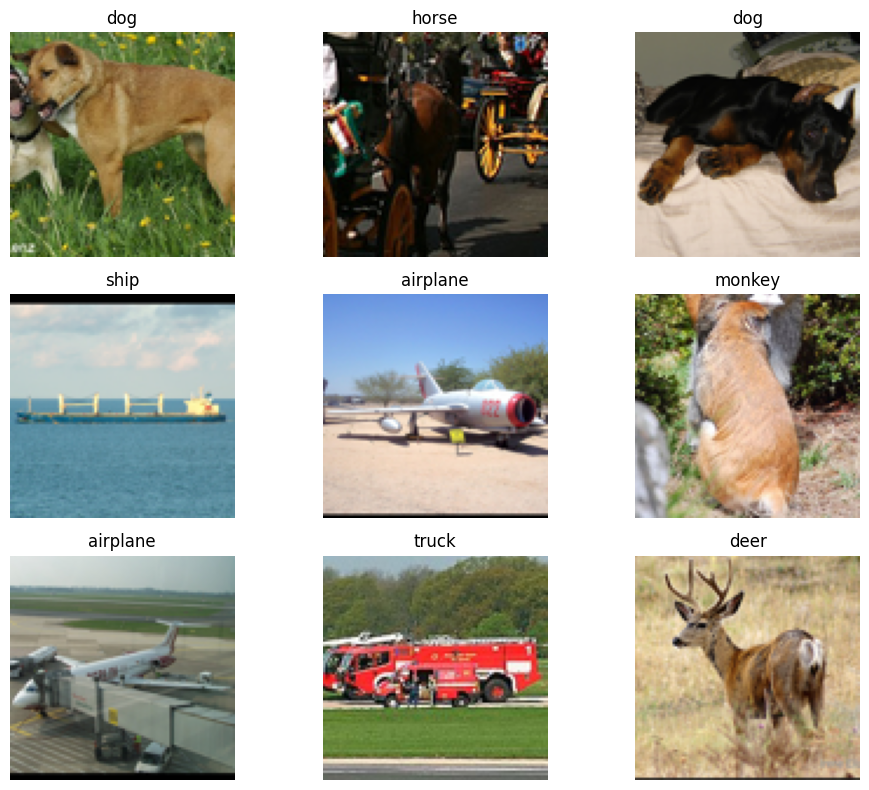

Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Image shape (C,H,W): (96, 96) (= 3 x 96 x 96)
Image dtype: uint8
Label dtype: <class 'numpy.ndarray'>


In [ ]:
# Display a small grid of samples
fig = plt.figure(figsize=(10, 8))
for i in range(9):
    j = random.randint(0, full_train_X.shape[0]-1)
    img, lbl = full_train_X[j], full_train_y[j]
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(np.transpose(img, (1,2,0)))
    ax.set_title(full_class_names[lbl])
    ax.axis("off")
plt.tight_layout()
plt.show()

# Dataset summary in a table
print("Classes:", full_class_names)
print("Image shape (C,H,W):", full_train_X[0][0].shape, "(= 3 x 96 x 96)")
print("Image dtype:", full_train_X[0][0].dtype)
print("Label dtype:", type(full_train_X[0][1]))

###

## Build a 2-class subset (cat vs ship)

To make training faster and easier to debug, we first restrict the dataset to only two classes, ships and cats. This is:

- Old class IDs: `cat=3`, `ship=8` (based on STL-10 order)
- New class IDs: `cat→0`, `ship→1`

In [ ]:
# ===========================================================================
# First, let us train a 2-class classifier.
# ===========================================================================

# ===================
# Let's select from the dataset only samples of classes 'cat' and 'ship'.
# We have arbitrarily chosen these two classes.
# You may try some other pair of classes if you wish to.
# ===================
ID_C1_OLD, ID_C2_OLD = 3, 8 # C1: CAT, C2: SHIP
ID_C1_NEW, ID_C2_NEW = 0, 1

# ===================
# function to delete all the classes other than the cat and ship classes
# ===================
# inputs:
#    X: images from all classes
#    y: labels from all classes
#    split: train / test
# outputs:
#    X_out: images from only cats and ships
#    y_out: labels from only cats and ships
# ===================
def subsplit_two_classes(X, y, split):

    indices = np.where(np.logical_or(y==ID_C1_OLD, y==ID_C2_OLD))
    X_out = X[indices]
    y_out = y[indices]
    y_out = (y_out == ID_C1_OLD).astype(int) * ID_C1_NEW + (y_out == ID_C2_OLD).astype(int) * ID_C2_NEW
    print('Created "{}" subsplit with only 2 classes with sizes: Images {}, labels {}'.format(split, X_out.shape, y_out.shape))
    return X_out, y_out

# ===================
# make the training and test datasets so that they contain only the two classes of interest
# ===================
train_two_classes_X, train_two_classes_y = subsplit_two_classes(full_train_X,
                                                                full_train_y,
                                                                'train')

test_two_classes_X, test_two_classes_y = subsplit_two_classes(full_test_X,
                                                              full_test_y,
                                                              'test')

class_names_two_classes = [full_class_names[i] for i in (ID_C1_OLD, ID_C2_OLD)]

Created "train" subsplit with only 2 classes with sizes: Images (1000, 3, 96, 96), labels (1000,)
Created "test" subsplit with only 2 classes with sizes: Images (1600, 3, 96, 96), labels (1600,)


###

### Visualize the new 2-class subset

We may recycle the data visualisation code chunk. Now, one should see only cats and ships.

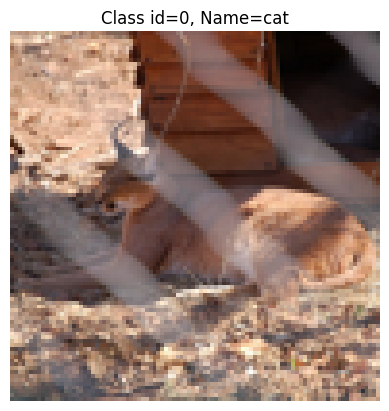

In [ ]:
# ===================
# visualize some examples from the modified datasets
# ===================
i = random.randint(0, train_two_classes_X.shape[0]-1)
visualize_sample(train_two_classes_X[i],
                 train_two_classes_y[i],
                 class_names_two_classes)

###

## PyTorch Dataset + DataLoader
We wrap NumPy arrays with `ArrayDataset` so PyTorch can batch them using `DataLoader`.

We create loaders for both:
- 2-class train/test
- 10-class train/test

In [ ]:
# ===========================================================================
# Wrap our dataset into pytorch Dataset class so it can further be used in DataLoader for batch grouping
# ===========================================================================
class ArrayDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

 # ===================
 # set the batch size here
 # ===================
BATCH_SIZE = 64
# ===================
# load the training and test datasets for the two-class classification problem
# https://pytorch.org/docs/stable/data.html
# ===================
loader_two_classes_train = DataLoader(dataset = ArrayDataset(train_two_classes_X, train_two_classes_y),
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

loader_two_classes_test = DataLoader(dataset = ArrayDataset(test_two_classes_X, test_two_classes_y),
                                     batch_size=1,
                                     shuffle=True)

# ===================
# load the training and test datasets for the ten-class classification problem
# ===================
loader_ten_classes_train = DataLoader(dataset = ArrayDataset(full_train_X, full_train_y),
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  drop_last=True)

loader_ten_classes_test = DataLoader(dataset = ArrayDataset(full_test_X, full_test_y),
                                 batch_size=1,
                                 shuffle=True)

###

## Define the CNN

We first naively create a preliminary version of our CNN model and experiment with it. This way, we can create our final model with more understanding and precision.

First architecture:
- 3× (Conv → BatchNorm → ReLU → MaxPool)
- Flatten → Dropout → FC(num_classes) → Softmax
- Ascending number of filter: 3, 8, 24, 64

Normalization is done inside `forward()`:
- Convert `uint8` to float in [0,1].
- Normalize to approximately [-1,1] via `(x-0.5)/0.5`.

In [ ]:
# ===========================================================================
# Define neural network
# ===========================================================================

# Change the number of fliters:
#     num_filters = [3, 6, 12, 24, 64]

class CNN(nn.Module):

  # ===================
  # A simple CNN (Acne-CNN style) adapted for STL-10 (96x96 RGB)
  # Conv -> ReLU -> MaxPool stacks + 2 FC layers
  # ===================
    def __init__(self, num_out_classes):
        super(CNN, self).__init__()

        # Input: (N, 3, 96, 96)
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)   # -> (N, 8, 48, 48)

        self.conv2 = nn.Conv2d(8, 24, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(24)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)   # -> (N, 24, 24, 24)

        self.conv3 = nn.Conv2d(24, 64, kernel_size=3, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)   # -> (N, 64, 12, 12)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn4   = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)   # -> (N, 128, 6, 6)

        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_out_classes)

    def forward(self, x):
        # x is uint8 in [0,255]
        x = x.float() / 255.0
        # normalize to [-1, 1]
        x = (x - 0.5) / 0.5

        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x





###

## Accuracy function

We compute classification accuracy by taking the `argmax` over logits and comparing with ground-truth labels. Accuracy will be our main criterion for distinguishing between models.


In [ ]:
# ===========================================================================
# function to compute the accuracy of the CNN
# ===========================================================================
def compute_accuracy(data_loader,
                     cnn,
                     split,
                     print_output = True):

    cnn.eval() # sets the model into evaluation mode
    total_accuracy = 0
    total_samples = 0

    for i, batch in enumerate(data_loader):

        # get the inputs and labels
        X_batch, y_batch = batch

        # calculate predictions given a batch of samples
        predictions_batch = cnn(X_batch)

        # convert each prediction into a class id
        _, vals = torch.max(predictions_batch, 1)

        # calculate the amount of predicted class ids matching the ground truth and increment counters
        total_accuracy += (vals == y_batch.type(torch.long)).int().sum()
        total_samples += y_batch.shape[0]

        out_accuracy = int(total_accuracy) * 1.0 / total_samples

    if print_output:
        print('Accuracy over "{}" split is {:02f}%'.format(split, 100 * out_accuracy))

    return 100 * out_accuracy

###

## Evaluate before training (2-class)

Before training, accuracy should be close to random guessing, i.e., ~50%.


In [ ]:
# ===========================================================================
# create an instance of the above defined CNN class
# ===========================================================================
cnn_two_classes = CNN(num_out_classes = 2)

# ===========================================================================
# compute the accuracy of the CNN... we have not yet trained it, so what do you expect the accuracy to be??
# ===========================================================================
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test')

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy over "train" split is 50.208333%
Accuracy over "test" split is 50.937500%


50.9375

###

## Training loop

We define our training function. We opt for using:
- **Loss:** `CrossEntropyLoss` (multi-class classification)
- **Optimizer:** Adam

We furthermore track the accuracy in each epoch.

In [ ]:
# ===========================================================================
# function for training the model
# ===========================================================================
def train(cnn,
          loader_train,
          loader_test,
          num_epochs,
          learning_rate = 0.001,
          track_accuracy = False):

    # ===================
    # loss function
    # ===================
    # *choose loss here
    criterion = nn.CrossEntropyLoss()


    # ===================
    # optimizer
    # ===================

    # *choose optimizer here
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

    # ===================
    # set the model into training mode
    # ===================
    cnn.train()

    tr_acc = []
    ts_acc = []

    # ===================
    # In each epoch, the optimizer operation is run on each batch
    # ===================
    for epoch in range(num_epochs):

        epoch_loss = 0.0

        for i, batch in enumerate(loader_train):

            X_batch, y_batch = batch
            y_batch = y_batch.type(torch.long)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            predictions_batch = cnn(X_batch)


            # loss for the provided predictions and ground truth labels
            # =====================================================
            loss = criterion(predictions_batch, y_batch)

            epoch_loss += float(loss)

            # backward pass
            loss.backward()

            # update of learnable parameters according to gradients
            optimizer.step()

        # ===================
        # track of the training and test accuracy.
        # ===================
        if track_accuracy:
            tr_acc.append(compute_accuracy(data_loader = loader_train,
                                           cnn = cnn,
                                           split = 'train',
                                           print_output = False))
            ts_acc.append(compute_accuracy(data_loader = loader_test,
                                           cnn = cnn,
                                           split = 'test',
                                           print_output = False))

        epoch_loss /= len(loader_train)
        print('Epoch {}/{} training loss {:02f}'.format(epoch+1, num_epochs, epoch_loss))

    if track_accuracy:
        plt.figure()
        plt.plot(np.array(tr_acc))
        plt.plot(np.array(ts_acc))
        plt.legend(['training accuracy', 'test accuracy'])
        plt.xlabel('training iterations')
        plt.show()
        plt.close()

    print('Finished Training')

###

## Train the 2-class CNN

We train our model for the 2-class classification scenario. After training, training accuracy should increase, and test accuracy should improve above, at least, chance level.


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/tmp/ipython-input-70619504.py:61: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  epoch_loss += float(loss)


Epoch 1/20 training loss 0.594882
Epoch 2/20 training loss 0.470632
Epoch 3/20 training loss 0.410979
Epoch 4/20 training loss 0.398352
Epoch 5/20 training loss 0.388394
Epoch 6/20 training loss 0.380079
Epoch 7/20 training loss 0.399435
Epoch 8/20 training loss 0.385647
Epoch 9/20 training loss 0.375985
Epoch 10/20 training loss 0.363685
Epoch 11/20 training loss 0.357308
Epoch 12/20 training loss 0.359832
Epoch 13/20 training loss 0.363110
Epoch 14/20 training loss 0.359327
Epoch 15/20 training loss 0.395565
Epoch 16/20 training loss 0.357840
Epoch 17/20 training loss 0.346194
Epoch 18/20 training loss 0.341507
Epoch 19/20 training loss 0.338649
Epoch 20/20 training loss 0.342536


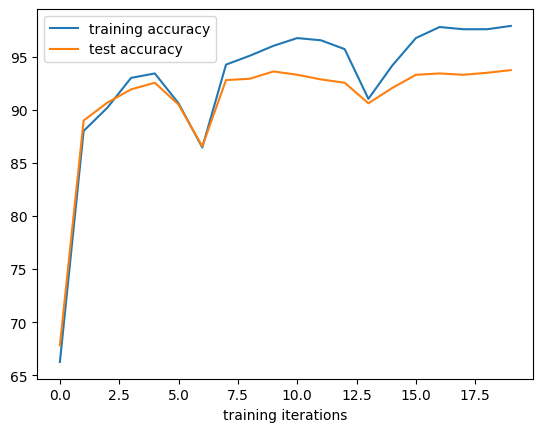

Finished Training
Accuracy over "train" split is 97.812500%
Accuracy over "test" split is 93.750000%


93.75

In [ ]:
# ===========================================================================
# call to the train function
# ===========================================================================
train(cnn = cnn_two_classes,
      loader_train = loader_two_classes_train,
      loader_test = loader_two_classes_test,
      num_epochs = 20,
      track_accuracy = True)

# ===========================================================================
# reevaluation of accuracy after training
# ===========================================================================
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test')




The final model achieves a total of ~94% accuracy, without signs of overfitting throughout the first 20 epochs (if the number of epochs increased, the model would start overfitting, i.e., the test accuracy would decrease as a result of an unnecessarily high training accuracy). Thus, we could consider ourselves successful in the task to some extent.

###

## Parameter testing

Now that we have concluded that our model (kind of) worked for the 2-class classification case, we experiment with the 10-class general setting in order to choose the most convenient model parameters. We are particularly interested in the number of filters and the number of layers (i.e., respectively, the network’s width and depth).

### Number of filters


We train our model with 3, 6, 12, 24 and 64 filters per layer.

#### 10-class CNN with 3 filters per layer
---

Epoch 1/15 training loss 2.707234
Epoch 2/15 training loss 2.492303
Epoch 3/15 training loss 2.323321
Epoch 4/15 training loss 2.218926
Epoch 5/15 training loss 2.145634
Epoch 6/15 training loss 2.057208
Epoch 7/15 training loss 1.977369
Epoch 8/15 training loss 1.908092
Epoch 9/15 training loss 1.851094
Epoch 10/15 training loss 1.800240
Epoch 11/15 training loss 1.767132
Epoch 12/15 training loss 1.743160
Epoch 13/15 training loss 1.711729
Epoch 14/15 training loss 1.692987
Epoch 15/15 training loss 1.664054


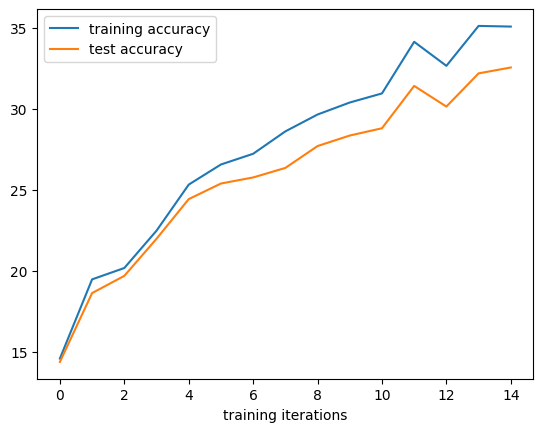

Finished Training
Accuracy over "train" split is 35.016026%
Accuracy over "test" split is 32.550000%


32.550000000000004

In [ ]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

#### 10-class CNN with 6 filters per layer
---

Epoch 1/15 training loss 2.575524
Epoch 2/15 training loss 2.316730
Epoch 3/15 training loss 2.052825
Epoch 4/15 training loss 1.795539
Epoch 5/15 training loss 1.657824
Epoch 6/15 training loss 1.591702
Epoch 7/15 training loss 1.535007
Epoch 8/15 training loss 1.504267
Epoch 9/15 training loss 1.483095
Epoch 10/15 training loss 1.462540
Epoch 11/15 training loss 1.440344
Epoch 12/15 training loss 1.429786
Epoch 13/15 training loss 1.420919
Epoch 14/15 training loss 1.399383
Epoch 15/15 training loss 1.371171


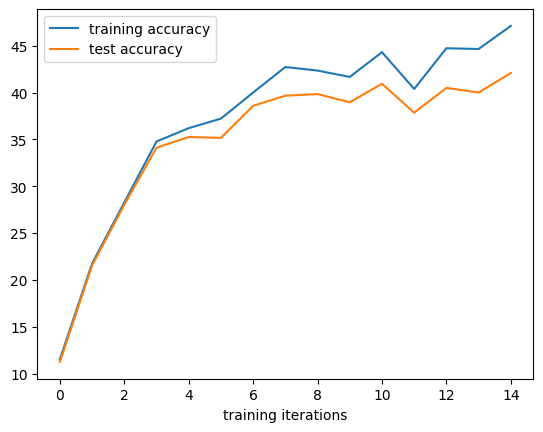

Finished Training
Accuracy over "train" split is 47.135417%
Accuracy over "test" split is 42.087500%


42.0875

In [ ]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

#### 10-class CNN with 12 filters per layer
---



Epoch 1/15 training loss 2.534402
Epoch 2/15 training loss 1.921685
Epoch 3/15 training loss 1.613089
Epoch 4/15 training loss 1.530306
Epoch 5/15 training loss 1.468072
Epoch 6/15 training loss 1.408173
Epoch 7/15 training loss 1.380233
Epoch 8/15 training loss 1.326178
Epoch 9/15 training loss 1.303012
Epoch 10/15 training loss 1.252729
Epoch 11/15 training loss 1.229506
Epoch 12/15 training loss 1.202841
Epoch 13/15 training loss 1.183558
Epoch 14/15 training loss 1.163180
Epoch 15/15 training loss 1.110320


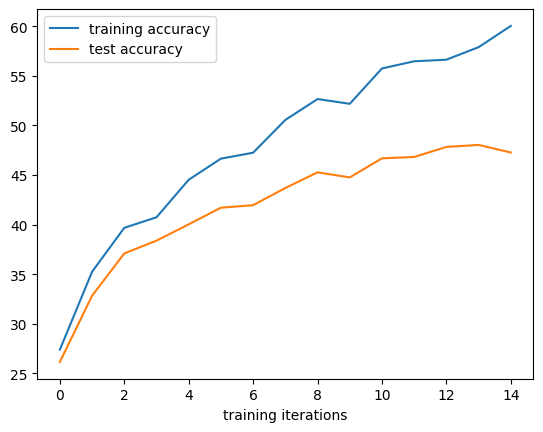

Finished Training
Accuracy over "train" split is 60.076122%
Accuracy over "test" split is 47.275000%


47.275

In [ ]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

#### 10-class CNN with 24 filters per layer
---

Epoch 1/15 training loss 2.396979
Epoch 2/15 training loss 1.623808
Epoch 3/15 training loss 1.410526
Epoch 4/15 training loss 1.279705
Epoch 5/15 training loss 1.193547
Epoch 6/15 training loss 1.084384
Epoch 7/15 training loss 1.000078
Epoch 8/15 training loss 0.943554
Epoch 9/15 training loss 0.843821
Epoch 10/15 training loss 0.752990
Epoch 11/15 training loss 0.680703
Epoch 12/15 training loss 0.633828
Epoch 13/15 training loss 0.580388
Epoch 14/15 training loss 0.475302
Epoch 15/15 training loss 0.426388


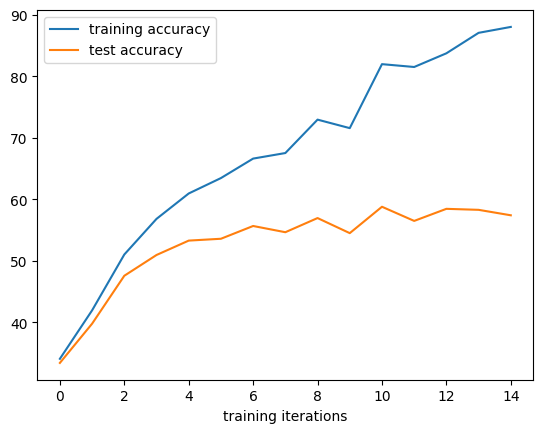

Finished Training
Accuracy over "train" split is 88.020833%
Accuracy over "test" split is 57.412500%


57.4125

In [ ]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

#### 10-class CNN with 64 filters per layer
---

Epoch 1/15 training loss 2.062861
Epoch 2/15 training loss 1.415334
Epoch 3/15 training loss 1.204685
Epoch 4/15 training loss 1.073098
Epoch 5/15 training loss 0.944602
Epoch 6/15 training loss 0.824838
Epoch 7/15 training loss 0.703391
Epoch 8/15 training loss 0.598957
Epoch 9/15 training loss 0.470317
Epoch 10/15 training loss 0.374060
Epoch 11/15 training loss 0.253523
Epoch 12/15 training loss 0.196334
Epoch 13/15 training loss 0.197063
Epoch 14/15 training loss 0.127300
Epoch 15/15 training loss 0.119092


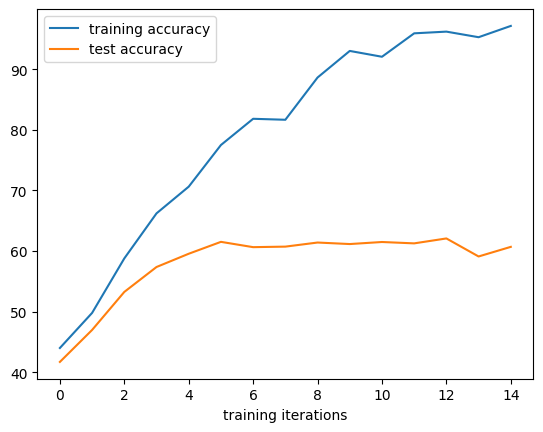

Finished Training
Accuracy over "train" split is 97.135417%
Accuracy over "test" split is 60.700000%


60.699999999999996

In [ ]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

We note that, as the number of filters increases, so does the accuracy of the model. This fact is consistent with our intuition, since more filters imply more parameters, allowing the model to capture more inner data patterns. However, it is important to notice that the test accuracies in the 24- and 64-filter cases are ~57% and ~60%, respectively. Compared to the previous accuracy differences, this is not remarkable, and the cost of gaining this small improvement is that the training process becomes four times longer.


We now have an idea of the number of filters we should use for our final model.

### Number of layers testing

On the other hand, we also need to choose a certain number of layers. We experiment with one, two, three, and four layers.

#### 10-class 1-dense-layer CNN
---


Epoch 1/15 training loss 3.454537
Epoch 2/15 training loss 2.525399
Epoch 3/15 training loss 2.160963
Epoch 4/15 training loss 1.884185
Epoch 5/15 training loss 1.610445
Epoch 6/15 training loss 1.306358
Epoch 7/15 training loss 1.459094
Epoch 8/15 training loss 1.183299
Epoch 9/15 training loss 1.033649
Epoch 10/15 training loss 0.926834
Epoch 11/15 training loss 0.838854
Epoch 12/15 training loss 0.773311
Epoch 13/15 training loss 0.663275
Epoch 14/15 training loss 0.561149
Epoch 15/15 training loss 0.583984


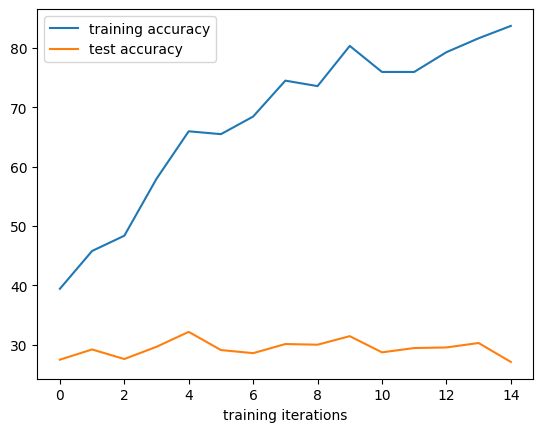

Finished Training
Accuracy over "train" split is 83.693910%
Accuracy over "test" split is 27.125000%


27.125

In [ ]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

#### 10-classes 2-layer CNN
---

Epoch 1/15 training loss 2.859522
Epoch 2/15 training loss 1.348023
Epoch 3/15 training loss 1.045564
Epoch 4/15 training loss 0.834456
Epoch 5/15 training loss 0.648883
Epoch 6/15 training loss 0.510341
Epoch 7/15 training loss 0.374514
Epoch 8/15 training loss 0.283317
Epoch 9/15 training loss 0.192996
Epoch 10/15 training loss 0.128850
Epoch 11/15 training loss 0.093556
Epoch 12/15 training loss 0.068841
Epoch 13/15 training loss 0.039913
Epoch 14/15 training loss 0.027583
Epoch 15/15 training loss 0.018771


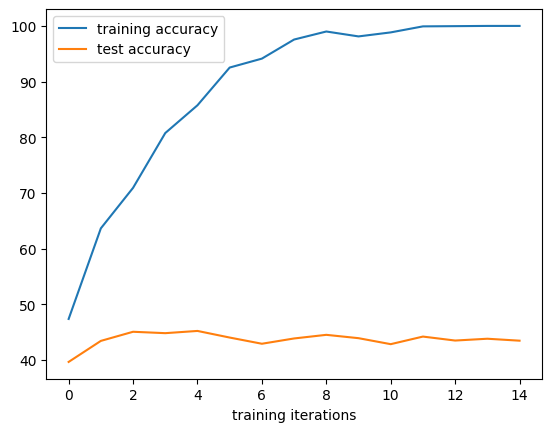

Finished Training
Accuracy over "train" split is 100.000000%
Accuracy over "test" split is 43.475000%


43.475

In [ ]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

#### 10-classes 3-layer CNN
---

Epoch 1/15 training loss 2.510648
Epoch 2/15 training loss 1.313686
Epoch 3/15 training loss 1.026329
Epoch 4/15 training loss 0.812148
Epoch 5/15 training loss 0.592907
Epoch 6/15 training loss 0.395897
Epoch 7/15 training loss 0.264176
Epoch 8/15 training loss 0.170042
Epoch 9/15 training loss 0.097961
Epoch 10/15 training loss 0.059921
Epoch 11/15 training loss 0.100828
Epoch 12/15 training loss 0.048241
Epoch 13/15 training loss 0.076229
Epoch 14/15 training loss 0.081341
Epoch 15/15 training loss 0.042297


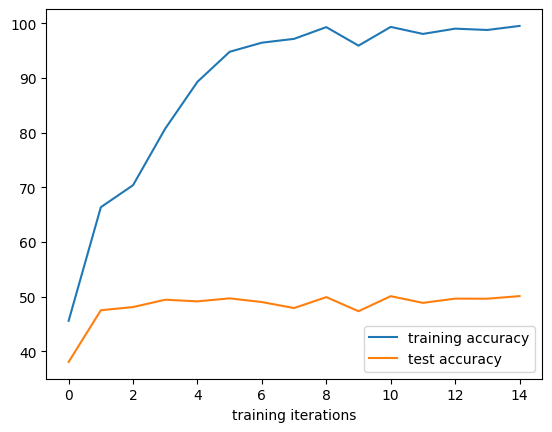

Finished Training
Accuracy over "train" split is 99.539263%
Accuracy over "test" split is 50.125000%


50.125

In [ ]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

#### 10-classes 4-layer CNN
---

Epoch 1/15 training loss 2.025362
Epoch 2/15 training loss 1.286453
Epoch 3/15 training loss 1.028806
Epoch 4/15 training loss 0.843987
Epoch 5/15 training loss 0.673433
Epoch 6/15 training loss 0.503315
Epoch 7/15 training loss 0.329016
Epoch 8/15 training loss 0.232950
Epoch 9/15 training loss 0.149849
Epoch 10/15 training loss 0.082738
Epoch 11/15 training loss 0.032433
Epoch 12/15 training loss 0.016996
Epoch 13/15 training loss 0.008203
Epoch 14/15 training loss 0.005812
Epoch 15/15 training loss 0.066714


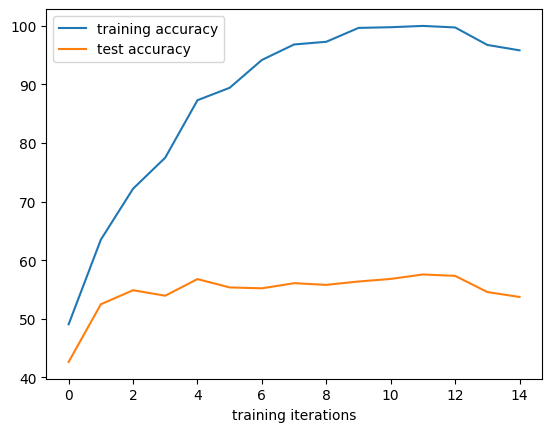

Finished Training
Accuracy over "train" split is 95.813301%
Accuracy over "test" split is 53.725000%


53.725

In [ ]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

As expected, each additional layer results in an accuracy improvement.

With all this new insight about the model features, we design our final version.

###

## Final CNN

The architecture of our definitive model is the following:

*   4× (Conv → BatchNorm → ReLU → MaxPool)
*   Flatten → FC(256) → Dropout → FC(num_classes) → Softmax

Moreover, for the convolutional layers, the chosen widths are, consecutively:
*   3 (input) → 8 → 24 → 64 → 128 → 256


Epoch 1/15 training loss 1.903492
Epoch 2/15 training loss 1.367168
Epoch 3/15 training loss 1.201522
Epoch 4/15 training loss 1.044293
Epoch 5/15 training loss 0.881932
Epoch 6/15 training loss 0.749794
Epoch 7/15 training loss 0.588063
Epoch 8/15 training loss 0.431687
Epoch 9/15 training loss 0.258983
Epoch 10/15 training loss 0.189488
Epoch 11/15 training loss 0.139426
Epoch 12/15 training loss 0.094586
Epoch 13/15 training loss 0.092574
Epoch 14/15 training loss 0.130420
Epoch 15/15 training loss 0.063945


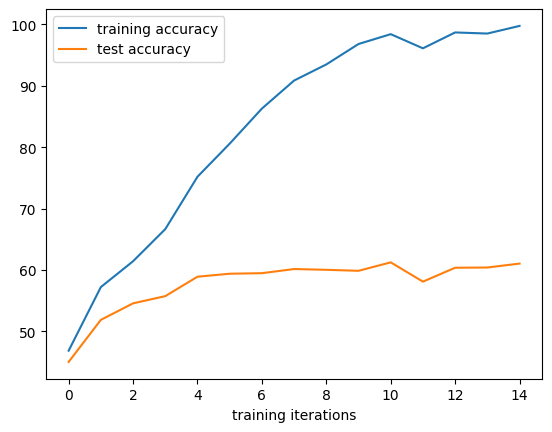

Finished Training
Accuracy over "train" split is 99.739583%
Accuracy over "test" split is 61.037500%


61.0375

In [ ]:
# =================================
# create instance of the CNN class
# =================================
cnn_ten_classes = CNN(num_out_classes = 15)


# =================================
# train CNN
# =================================
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 15,
      track_accuracy = True)

# ================================
# compute the accuracy with the trained CNN
# ================================
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

Our last model showcases a total accuracy of ~61%, the best result we have had so far. Despite this fact, it is worth mentioning that the training data is highly overfitted, as shown by the accuracy reaching ~99.74%. We could expect that, if some randomness were added to the training data, the training accuracy might be reduced and, thus, the model would achieve better generalisation. This randomness could be applied via augmentations and rotations, for example.


###

###

###

## Team work and distribution

All members initially attempted to work on the entire set of tasks, discussing collectively how to effectively approach the problem. Each member, however, had their defined role:
- Osbert Villasis for Data and processing lead, whose main function was loading and implementing correctly the data pipelins depending on the used package, wether Tensorflow or PyTorch.
- Diego Plumed for the CNN architecture and theory lead, whose responsability was understanding and efficiently designing the CNN in both Tensorflow and PyTorch.
- Lastly, Ethan Ty for implementation and debugging lead, which concerned debugging and undergoing thorough analysis of the data handling.

Thus, we all made individual contributions, including explaining the code, debugging errors, and ensuring that the target goals for both tasks were fully addressed.


At the beginning, we executed our codes on our personal laptops using local Python kernels. Later, we moved to GitHub and Google Colab, which allowed us to refine the code collaboratively and manage a repository of our different code iterations. This workflow also facilitated sharing results and tracking progress easily.


Artificial intelligence tools were used to assist in identifying errors, debugging the code, and providing explanations for issues that arose during development. This support enabled us to focus on understanding the underlying logic and improving the model’s design.


Overall, our collaborative approach combined individual efforts, collective discussion, and AI-assisted troubleshooting, which allowed us to optimize both the coding process and the experimental design.
